In [2]:
import sys
sys.path.append('./../../designer/script/')
from gets.get_spectrum import get_spectrum_simple
from design import DesignSimple
from film import FilmSimple
from spectrum import SpectrumSimple
from utils.plot_spectrum import plot_spectrum
import numpy as np
import copy
from utils.loss import calculate_RMS
import matplotlib.pyplot as plt
import gets.get_intermediate_transfer_matrix as get_W
from gets.get_E import get_E



In [3]:


def equal_optical_thickness(f: FilmSimple, d_min):
    d = f.get_d()
    i = 1
    count = 0
    while i < d.shape[0] - 1:
        if d[i] < d_min:
            n_arr = f.calculate_n_array(np.array([750]))
            optical_ratio = n_arr[0, i + 1] / n_arr[0, i]
            d[i - 1] += optical_ratio * d[i] + d[i + 1]
            d = np.delete(d, [i, i + 1])
            i -= 1
            count += 1
        i += 1
    f.update_d(d)
    return count

def search_ot_substitution(f: FilmSimple, f_origin: FilmSimple, d_min):
    d = f.get_d()
    i = 1
    count = 0
    ratios = []
    while i < d.shape[0] - 1:
        if d[i] < d_min:
            n_arr = f.calculate_n_array(np.array([750]))
            optical_ratio = n_arr[0, i + 1] / n_arr[0, i]
            m = calculate_RMS(f, f_origin)

            for r in np.linspace(0, d_min * 10, 10):
                d_tmp = d.copy()
                # substitute
                d_tmp[i - 1] += r * optical_ratio * d[i] + d[i + 1]
                d_tmp = np.delete(d_tmp, [i, i + 1])

                f.update_d(d_tmp)
                m = calculate_RMS(f, f_origin)
                if r == 0. or m < best_m: # first search set as tmp best
                    best_m = m
                    best_d = d_tmp.copy()
                    best_r = r
            d = best_d
            ratios.append(best_r)
            count += 1

            i -= 1
        i += 1
    f.update_d(d)
    return count, ratios

def search_keeplayer_substitution(f: FilmSimple, f_origin: FilmSimple, d_min, search=None):
    search = np.linspace(d_min, d_min * 100, 100) if search is None else search
    d = f.get_d()
    i = 1
    count = 0
    sub_d_s = []
    merit_record = []
    d_record = []
    while i < d.shape[0] - 1:
        if d[i] < d_min:
            n_arr = f.calculate_n_array(np.array([750]))
            optical_ratio = n_arr[0, i + 1] / n_arr[0, i]

            this_merit_record = []
            this_d_record = []
            for r in search:
                d_iminus1_tmp = d[i]

                d[i] = r
                this_d_record.append(r)

                f.update_d(d)
                m = calculate_RMS(f, f_origin)
                this_merit_record.append(m)
                # print(m)
                if r == search[0] or m < best_m: # first search set as tmp best
                    best_m = m
                    best_d = d.copy()
                    best_r = r
                
                d[i] = d_iminus1_tmp # restore to search for others
            d = best_d
            sub_d_s.append(best_r)
            count += 1
            merit_record.append(this_merit_record)
            d_record.append(this_d_record)        
        i += 1

    f.update_d(d)
    return count, sub_d_s, merit_record, d_record

# the first two is not correct but performs somehow better...
def optimal_and_thin_film_approx_substitution_onestep(f: FilmSimple, d_min):
    '''
    Assuming the layers adjacent to very thin films are thin enough. Use linerization to get 
    an analytical optimal solution in the first order approximation.

    One step: thickness compensation always adds to the previous layer. When adjaecnt thin layers,
    one of their correction would be neglected
    '''
    # assume single spec
    assert len(f.get_all_spec_list()) == 1, "too many spectrums"
    # load params to the get W function
    d = f.get_d()
    spec = f.get_spec()
    count = 0
    ratios = []
    delete_indices = []
    i = 1
    while i < d.shape[0]: # neglect the last layer
        if f.get_d()[i] < d_min:
            Q1 = get_W.get_W_before_ith_layer(
                spec.WLS,
                f.get_d(),
                spec.n,
                spec.n_sub,
                spec.n_inc,
                spec.INC_ANG, 
                i
            )

            Q2 = get_W.get_W_after_ith_layer(
                spec.WLS,
                f.get_d(),
                spec.n,
                spec.n_sub,
                spec.n_inc,
                spec.INC_ANG, 
                i
            )
            
            """
            Below is how A is defined. Note that x is to be solved
            A = np.empty((spec.WLS.shape[0] * 2, 2, 2), dtype='complex128')
            for k in range(spec.WLS.shape[0]):
                this_n = spec.n[k, i] # to be substituted, material A
                next_n = spec.n[k, i + 1] # to substitute, material B
                
                this_cos = np.sqrt(1 - (1 / this_n * np.sin(spec.INC_ANG)) ** 2)
                next_cos = np.sqrt(1 - (1 / next_n * np.sin(spec.INC_ANG)) ** 2)
            
                # s-polarized, x is the increment in d[i+1] to solve for
                A[k, :, :] = np.array([[0, -1j * 2 * np.pi / spec.WLS[k] * (next_n**2 * x - this_n**2 * d[i])], 
                            [-1j * 2 * np.pi / spec.WLS[k] * (x * next_cos**2 - d[i] * this_cos**2), 0]])
                # p-polarized
                A[k + spec.WLS.shape[0], :, :] = np.array([[0, -1j * 2 * np.pi / spec.WLS[k] * (x - d[i])], 
                            [-1j * 2 * np.pi / spec.WLS[k] * (x * next_n**2 * next_cos**2 - d[i] * this_n**2 * this_cos**2), 0]])
            """
            E = get_E(
                spec.WLS,
                f.get_d(),
                spec.n,
                spec.n_sub,
                spec.n_inc,
                spec.INC_ANG
            )
            
            nB = np.repeat(spec.n[:, i + 1], 2, axis=0)
            nA = np.repeat(spec.n[:, i], 2, axis=0)
            wls = np.repeat(spec.WLS, 2, axis=0)
            dA = f.get_d()[i]
            
            A_1 = np.array([[[0, 1], [0, 0]] for k in range(2 * spec.WLS.shape[0])])
            A_2 = np.array([[[0, 0], [1, 0]] for k in range(2 * spec.WLS.shape[0])])
            # solve A_lambda1 and A_lambda2 respectively and acquire the ratio between d_B and d_A
            partialL_A_1 = np.transpose(Q1, (0, 2, 1)).conj() @ Q1 @ A_1 @ Q2 @ np.transpose(Q2, (0, 2, 1)).conj()
            partialL_A_2 = np.transpose(Q1, (0, 2, 1)).conj() @ Q1 @ A_2 @ Q2 @ np.transpose(Q2, (0, 2, 1)).conj()
            a1 = nB**2 * partialL_A_1[:, 0, 1] + nB ** -2 * partialL_A_1[:, 1, 0]
            a2 = nB**2 * partialL_A_2[:, 0, 1] + nB ** -2 * partialL_A_2[:, 1, 0]

            '''
            Then solve 
                lambda1 / lambda2 = (nB^2 dB - nA^2 dA) / (nB^-2 dB - nA^-2 dA)
            So
                dB = (nA^-2 dA (lambda1/lambda2) + nA^2 dA) / (-lambda1 / lambda2 nB^-2 + nB^2)
            '''
            dB = dA * (np.dot(a1, (nA**2 / wls)) - np.dot(a2, 1 /(nA**2 * wls))) / \
                (np.dot(a1, (nB**2 / wls)) - np.dot(a2, 1 /(nB**2 * wls)))

            # save substitution info
            this_ot_ratio = (nB[wls.shape[0]//2] * dB) / (nA[wls.shape[0]//2] * dA)
            count += 1
            ratios.append(this_ot_ratio)
            # update d
            i_to_add = i
            for i_to_del in delete_indices[::-1]:
                if i_to_del != i_to_add:
                    break
                else:
                    i_to_add -= 1
            
            if i == d.shape[0] - 1:
                d[i - 1] += dB
            else:
                d[i - 1] += d[i + 1] + dB
            delete_indices += [i, i + 1]
            i += 1

        i += 1
        # end loop

    
    d = np.delete(d, delete_indices).real
    f.update_d(d)
    return count, ratios


def optimal_and_thin_film_approx_substitution_greedy(f: FilmSimple, d_min):
    '''
    Assuming the layers adjacent to very thin films are thin enough. Use linerization to get 
    an analytical optimal solution in the first order approximation.
    '''
    # assume single spec
    assert len(f.get_all_spec_list()) == 1, "too many spectrums"
    # load params to the get W function
    d = f.get_d()
    spec = f.get_spec()
    count = 0
    ratios = []
    i = 1
    while i < d.shape[0] - 1: # neglect the last layer
        if d[i] < d_min:
            Q1 = get_W.get_W_before_ith_layer(
                spec.WLS,
                d,
                spec.n,
                spec.n_sub,
                spec.n_inc,
                spec.INC_ANG, 
                i
            )

            Q2 = get_W.get_W_after_ith_layer(
                spec.WLS,
                d,
                spec.n,
                spec.n_sub,
                spec.n_inc,
                spec.INC_ANG, 
                i
            )

            nB = np.repeat(spec.n[:, i + 1], 2, axis=0)
            nA = np.repeat(spec.n[:, i], 2, axis=0)
            wls = np.repeat(spec.WLS, 2, axis=0)
            dA = d[i]
            
            A_1 = np.array([[[0, 1], [0, 0]] for k in range(2 * spec.WLS.shape[0])])
            A_2 = np.array([[[0, 0], [1, 0]] for k in range(2 * spec.WLS.shape[0])])
            # solve A_lambda1 and A_lambda2 respectively and acquire the ratio between d_B and d_A
            # TODO: should have used hermite conjugate. Don't forget to check consistency in the real part!
            partialL_A_1 = np.transpose(Q1, (0, 2, 1)).conj() @ Q1 @ A_1 @ Q2 @ np.transpose(Q2, (0, 2, 1)).conj()
            partialL_A_2 = np.transpose(Q1, (0, 2, 1)).conj() @ Q1 @ A_2 @ Q2 @ np.transpose(Q2, (0, 2, 1)).conj()
            a1 = nB**2 * partialL_A_1[:, 0, 1] + nB ** -2 * partialL_A_1[:, 1, 0]
            a2 = nB**2 * partialL_A_2[:, 0, 1] + nB ** -2 * partialL_A_2[:, 1, 0]

            dB = dA * (np.dot(a1, (nA**2 / wls)) - np.dot(a2, 1 /(nA**2 * wls))) / \
                (np.dot(a1, (nB**2 / wls)) - np.dot(a2, 1 /(nB**2 * wls)))
            
            # save substitution info
            this_ot_ratio = (nB[wls.shape[0]//2] * dB) / (nA[wls.shape[0]//2] * dA)
            count += 1
            ratios.append(this_ot_ratio)

            # update d
            d[i + 1] += d[i - 1] + dB
            d = np.delete(d, [i, i - 1])
            d = d.real
            i -= 1
        i += 1
        # end loop

    if d[-1] < d_min:
        d = np.delete(d, -1)
    
    f.update_d(d)
    return count, ratios


def optimal_and_thin_film_approx_substitution_onestep_new(f: FilmSimple, d_min):
    '''
    Assuming the layers adjacent to very thin films are thin enough. Use linerization to get 
    an analytical optimal solution in the first order approximation.

    One step: thickness compensation always adds to the previous layer. When adjaecnt thin layers,
    one of their correction would be neglected
    '''
    # assume single spec
    assert len(f.get_all_spec_list()) == 1, "too many spectrums"
    # load params to the get W function
    d = f.get_d()
    spec = f.get_spec()
    count = 0
    ratios = []
    delete_indices = []
    i = 1
    while i < d.shape[0]: # neglect the last layer
        if f.get_d()[i] < d_min:
            dB, this_ot_ratio = calculate_dB(spec, f.get_d(), i)
            count += 1
            ratios.append(this_ot_ratio)
            # update d
            i_to_add = i
            for i_to_del in delete_indices[::-1]:
                if i_to_del != i_to_add:
                    break
                else:
                    i_to_add -= 1
            
            if i == d.shape[0] - 1:
                d[i - 1] += dB
            else:
                d[i - 1] += d[i + 1] + dB
            delete_indices += [i, i + 1]
            i += 1

        i += 1
        # end loop

    
    d = np.delete(d, delete_indices).real
    f.update_d(d)
    return count, ratios


def optimal_and_thin_film_approx_substitution_greedy_new(f: FilmSimple, d_min):
    '''
    Assuming the layers adjacent to very thin films are thin enough. Use linerization to get 
    an analytical optimal solution in the first order approximation.
    '''
    # assume single spec
    assert len(f.get_all_spec_list()) == 1, "too many spectrums"
    # load params to the get W function
    d = f.get_d()
    spec = f.get_spec()
    count = 0
    ratios = []
    i = 1
    while i < d.shape[0] - 1: # neglect the last layer
        if d[i] < d_min:
            dB, this_ot_ratio = calculate_dB(spec, d, i)
            count += 1
            ratios.append(this_ot_ratio)
            # update d
            d[i + 1] += d[i - 1] + dB
            d = np.delete(d, [i, i - 1])
            d = d.real

            i -= 1
        i += 1
        # end loop

    if d[-1] < d_min:
        d = np.delete(d, -1)
    
    f.update_d(d)
    return count, ratios

def calculate_dB(spec: SpectrumSimple, d, layer_index):
    i = layer_index
    Q1 = get_W.get_W_before_ith_layer(
        spec.WLS,
        d,
        spec.n,
        spec.n_sub,
        spec.n_inc,
        spec.INC_ANG, 
        i
    )

    Q2 = get_W.get_W_after_ith_layer(
        spec.WLS,
        d,
        spec.n,
        spec.n_sub,
        spec.n_inc,
        spec.INC_ANG, 
        i
    )

    nB = np.repeat(spec.n[:, i + 1], 2, axis=0)
    nA = np.repeat(spec.n[:, i], 2, axis=0)
    n_inc = np.repeat(spec.n_inc, 2, axis=0)
    cosA = np.sqrt(1 - ((n_inc / nA) * np.sin(spec.INC_ANG)) ** 2)
    cosB = np.sqrt(1 - ((n_inc / nB) * np.sin(spec.INC_ANG)) ** 2)
    wls = np.repeat(spec.WLS, 2, axis=0)
    dA = d[i]
    
    A_1 = np.array([[[0, 1], [0, 0]] for k in range(2 * spec.WLS.shape[0])])
    A_2 = np.array([[[0, 0], [1, 0]] for k in range(2 * spec.WLS.shape[0])])
    # solve A_lambda1 and A_lambda2 respectively and acquire the ratio between d_B and d_A
    # TODO: should have used hermite conjugate. Don't forget to check consistency in the real part!
    partialL_A_1 = np.transpose(Q1, (0, 2, 1)).conj() @ Q1 @ A_1 @ Q2 @ np.array([[1., 0.], [0., 0.]]) @ np.transpose(Q2, (0, 2, 1)).conj()
    partialL_A_2 = np.transpose(Q1, (0, 2, 1)).conj() @ Q1 @ A_2 @ Q2 @ np.array([[1., 0.], [0., 0.]]) @ np.transpose(Q2, (0, 2, 1)).conj()
    a1 = nA**2 * cosA**2 * partialL_A_1[:, 0, 1] + partialL_A_1[:, 1, 0]
    a2 = nB**2 * cosB**2 * partialL_A_2[:, 0, 1] + partialL_A_2[:, 1, 0]

    dB = dA * (np.dot(a1, (nA**2 * cosA**2 / wls)) - np.dot(a2, 1 / wls)) / \
        (np.dot(a1, (nB**2 * cosB**2 / wls)) - np.dot(a2, 1 / wls))
    
    # save substitution info
    this_ot_ratio = (nB[wls.shape[0]//2] * dB) / (nA[wls.shape[0]//2] * dA)

    return dB, this_ot_ratio
    

### test with random generated film

In [3]:
# Initialize
wls = np.linspace(500, 1000, 500)
inc_ang = 60.


def plot_film(f: FilmSimple):
    f.add_spec_param(inc_ang, wls)
    spectrum_before_sub = f.get_spec()
    spectrum_before_sub.calculate() # compile cuda kernel func
    # plot_spectrum(spectrum_before_sub)

np.random.seed(1)
f = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(200) * 30)
plot_film(f)

c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


KeyboardInterrupt: 

In [ ]:
f_sub1 = copy.deepcopy(f)

d_mins_1 = np.linspace(0, 10, 100)
losses_1 = []
for d_min in d_mins_1:
    count = equal_optical_thickness(f_sub1, d_min)
    losses_1.append(calculate_RMS(f, f_sub1))
    # print(merits[-1], "min d:", d_min, 'and', count, "layers deleted")


C:\Users\rfeng6\AppData\Local\Temp\ipykernel_10472\3637402555.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i - 1] += optical_ratio * d[i] + d[i + 1]


0 []


C:\Users\rfeng6\AppData\Local\Temp\ipykernel_20124\1006570856.py:35: ComplexWarning: Casting complex values to real discards the imaginary part
  d_tmp[i - 1] += r * optical_ratio * d[i] + d[i + 1]


2 [0.2244668911335578, 0.2244668911335578]
2 [0.2244668911335578, 0.2244668911335578]
2 [0.3367003367003367, 0.3367003367003367]
3 [0.4489337822671156, 0.0, 1.3468013468013469]
5 [0.0, 0.0, 0.5611672278338946, 1.1223344556677892, 0.5611672278338946]
10 [0.0, 0.0, 0.6734006734006734, 0.0, 0.0, 0.6734006734006734, 3.367003367003367, 0.6734006734006734, 2.0202020202020203, 1.3468013468013469]
10 [0.0, 0.0, 0.7856341189674523, 0.0, 0.0, 0.7856341189674523, 2.356902356902357, 0.7856341189674523, 2.356902356902357, 1.5712682379349046]
10 [0.0, 0.0, 0.0, 2.6936026936026938, 0.0, 0.8978675645342312, 1.7957351290684624, 0.8978675645342312, 2.6936026936026938, 0.8978675645342312]
12 [0.0, 0.0, 0.0, 1.01010101010101, 0.0, 0.0, 0.0, 1.01010101010101, 3.03030303030303, 0.0, 2.02020202020202, 2.02020202020202]
12 [0.0, 0.0, 0.0, 1.1223344556677892, 0.0, 0.0, 0.0, 0.0, 7.8563411896745245, 0.0, 2.2446689113355784, 2.2446689113355784]
12 [0.0, 0.0, 0.0, 1.2345679012345678, 0.0, 0.0, 0.0, 0.0, 7.4074074

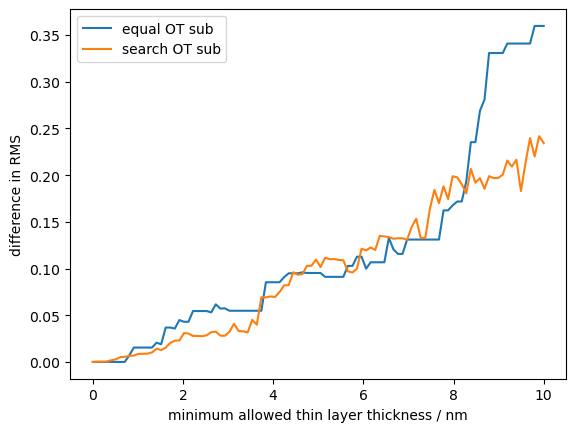

In [ ]:

d_mins_2 = d_mins_1.copy()
losses_2= []
# takes about 10 min to run
for d_min in d_mins_2:
    f_sub2 = copy.deepcopy(f)
    count, ratio = search_ot_substitution(f_sub2, f, d_min)
    print(count, ratio)
    losses_2.append(calculate_RMS(f, f_sub2))

# fig, ax = plt.subplots(1, 1)
# ax.plot(d_mins_1, losses_1, label='equal OT sub')
# ax.plot(d_mins_2, losses_2, label='search OT sub')

# ax.set_xlabel('minimum allowed thin layer thickness / nm')
# ax.set_ylabel('difference in RMS')
# ax.legend()

In [ ]:
d_mins_3 = d_mins_1.copy()
losses_3 = []
m_records = []
d_records = []

# takes about 60 mins to run
for d_min in d_mins_3:
    f_sub3 = copy.deepcopy(f)
    count, ratios, m_records_this_dmin, d_records_this_dmin = search_keeplayer_substitution(f_sub3, f, d_min)
    m_records.append(m_records_this_dmin)
    d_records.append(d_records_this_dmin)
    # print(count)
    losses_3.append(calculate_RMS(f, f_sub3))



KeyboardInterrupt: 

In [ ]:
# optim dE^2
d_mins_4 = d_mins_1.copy()
losses_4_new = []
ratios_4 = []
# takes~3min
for d_min in d_mins_4:
    f_sub4 = copy.deepcopy(f)
    count, ratio = optimal_and_thin_film_approx_substitution_onestep_new(f_sub4, d_min)
    ratios_4.append(ratio)
    losses_4_new.append(calculate_RMS(f, f_sub4))

# optim dE^2
d_mins_5 = d_mins_1.copy()
losses_5_new = []
ratios_5 = []
# takes~3min
for d_min in d_mins_5:
    f_sub5 = copy.deepcopy(f)
    count, ratio = optimal_and_thin_film_approx_substitution_greedy_new(f_sub5, d_min)
    ratios_5.append(ratio)
    losses_5_new.append(calculate_RMS(f, f_sub5))


c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\rfeng6\AppData\Local\Temp\ipykernel_10472\3637402555.py:311: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i - 1] += d[i + 1] + dB
C:\Users\rfeng6\AppData\Local\Temp\ipykernel_10472\3637402555.py:343: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i + 1] += d[i - 1] + dB


In [ ]:
# optim dE^2
d_mins_4 = d_mins_1.copy()
losses_4 = []
ratios_4 = []
# takes~3min
for d_min in d_mins_4:
    f_sub4 = copy.deepcopy(f)
    count, ratio = optimal_and_thin_film_approx_substitution_onestep(f_sub4, d_min)
    ratios_4.append(ratio)
    losses_4.append(calculate_RMS(f, f_sub4))

# optim dE^2
d_mins_5 = d_mins_1.copy()
losses_5 = []
ratios_5 = []
# takes~3min
for d_min in d_mins_5:
    f_sub5 = copy.deepcopy(f)
    count, ratio = optimal_and_thin_film_approx_substitution_greedy(f_sub5, d_min)
    ratios_5.append(ratio)
    losses_5.append(calculate_RMS(f, f_sub5))

c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\rfeng6\AppData\Local\Temp\ipykernel_10472\3637402555.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i - 1] += d[i + 1] + dB
C:\Users\rfeng6\AppData\Local\Temp\ipykernel_10472\3637402555.py:264: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i + 1] += d[i - 1] + dB


In [ ]:
ratios_4

[[],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [(0.5368011964628737-0.0012716022649647508j)],
 [(0.5647048572070209-0.007762789904860482j),
  (0.5399144239930057+0.0009529491468967165j)],
 [(0.5647048572070209-0.007762789904860482j),
  (0.5399144239930057+0.0009529491468967165j)],
 [(0.5647048572070209-0.007762789904860482j),
  (0.5399144239930057+0.0009529491468967165j)],
 [(0.5647048572070209-0.007762789904860482j),
  (0.5399144239930057+0.0009529491468967165j)],
 [(0.5647048572070209-0.007762789904860482j),
  (0.5399144239930057+0.0009529491468967165j)],
 [(0.5647048572070209-0.007762789904860482j),
  (0.5399144239930057+0.0009529491468967165j),
  (0.5423001528273705+0.005386308273797528j)],
 [(0.5647048572070209-0.007762789904860482j),
  (0.5399144239930057+0.0009529491468967165j),
  (1.9389417462443541+0.03037793102228535j),
  (0.5425399866987489+0.006212736035462832j)],
 [(0.5659478616946382-0.009938101732173528j),
  (0.5509836718417602-0.0029563651386635224j),
  (0.5425577833859738+0.

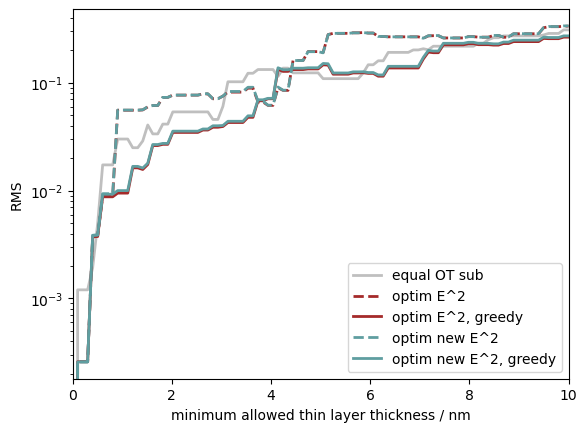

In [ ]:
# Note that losses are calculated at all wls, though some methods only involves evaluating n at some characteristic wl
fig, ax = plt.subplots(1, 1)
# NOTE: seems that gradual substitution performs better (sub thin film first then sub thicker)
ax.plot(d_mins_1, losses_1, label='equal OT sub', c='grey', alpha=0.5, linewidth=2, zorder=-1)
# ax.plot(d_mins_2, losses_2, label='search OT sub', c='peru', linewidth=2)
# ax.plot(d_mins_3, losses_3, label='search keepLayer sub')
ax.plot(d_mins_4, losses_4[:d_mins_4.shape[0]], label='optim E^2', c='brown', ls='--', linewidth=2)
ax.plot(d_mins_5, losses_5, label='optim E^2, greedy', c='brown', linewidth=2)

ax.plot(d_mins_4, losses_4_new, label='optim new E^2', c='cadetblue', ls='--', linewidth=2)
ax.plot(d_mins_5, losses_5_new, label='optim new E^2, greedy', c='cadetblue', linewidth=2)

ax.set_xlim(0, 10)
ax.set_xlabel('minimum allowed thin layer thickness / nm')
ax.set_yscale('log')
# ax.set_ylim(1e-2, None)
ax.set_ylabel('RMS')
ax.legend()

### Substitute trained films

In [4]:
# load file
from utils.load_designs import load_designs_single_spec
from utils.load_designs import init_film_single_spec

load_file_dir_SiO2_target_30layers = './../raw_design_result/50iters_0to2OT_200run_SiO2_target30layers/'
load_file_dir_TiO2_target_30layers = './../raw_design_result/50iters_0to2OT_200run_TiO2_target30layers/'
load_file_dir_SiO2_target_4layers = './../raw_design_result/50iters_0to2OT_200run_SiO2_target4layers/'
load_file_dir_TiO2_target_4layers = './../raw_design_result/50iters_0to2OT_200run_TiO2_target4layers/'


# create target film structure
# Initialize: config for TML
WLS = np.linspace(500, 1000, 500)
INC_ANG = 60.
wl = 750. # wl used for calculating OT

np.random.seed(1)
f_target_30layers = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(30) * 100) # target film
init_film_single_spec(f_target_30layers, INC_ANG, WLS)

np.random.seed(1)
f_target_4layers = FilmSimple("SiO2", "TiO2", "SiO2", np.random.random(4) * 750) # target film
init_film_single_spec(f_target_4layers, INC_ANG, WLS)


# load trained film from file
designs_SiO2: list[DesignSimple] = load_designs_single_spec(load_file_dir_SiO2_target_30layers, f_target_30layers, n_A='SiO2', n_B='TiO2', n_sub='SiO2')
designs_TiO2: list[DesignSimple] = load_designs_single_spec(load_file_dir_TiO2_target_30layers, f_target_30layers, n_A='TiO2', n_B='SiO2', n_sub='SiO2')
designs_SiO2_target4: list[DesignSimple] = load_designs_single_spec(load_file_dir_SiO2_target_4layers, f_target_4layers, n_A='SiO2', n_B='TiO2', n_sub='SiO2')
designs_TiO2_target4: list[DesignSimple] = load_designs_single_spec(load_file_dir_TiO2_target_4layers, f_target_4layers, n_A='TiO2', n_B='SiO2', n_sub='SiO2')


c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Trained film should not have zero geometric thickness (run 0)
Trained film should not have zero geometric thickness (run 0)
Trained film should not have zero geometric thickness (run 0)


c:\Users\rfeng6\Desktop\working\Thin-Film-Design\working\substitution\./../../designer/script\utils\load_designs.py:31: UserWarning: loadtxt: input contained no data: "./../raw_design_result/50iters_0to2OT_200run_SiO2_target4layers/run_23/iter_0"
  np.loadtxt(file_dir + f'run_{run_idx}/iter_0', dtype=float)*1000.
c:\Users\rfeng6\Desktop\working\Thin-Film-Design\working\substitution\./../../designer/script\utils\load_designs.py:31: UserWarning: loadtxt: input contained no data: "./../raw_design_result/50iters_0to2OT_200run_SiO2_target4layers/run_31/iter_0"
  np.loadtxt(file_dir + f'run_{run_idx}/iter_0', dtype=float)*1000.
c:\Users\rfeng6\Desktop\working\Thin-Film-Design\working\substitution\./../../designer/script\utils\load_designs.py:31: UserWarning: loadtxt: input contained no data: "./../raw_design_result/50iters_0to2OT_200run_SiO2_target4layers/run_32/iter_0"
  np.loadtxt(file_dir + f'run_{run_idx}/iter_0', dtype=float)*1000.
c:\Users\rfeng6\Desktop\working\Thin-Film-Design\workin

Trained film should not have zero geometric thickness (run 0)


C:\Users\rfeng6\AppData\Local\Temp\ipykernel_11212\1850212440.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i - 1] += optical_ratio * d[i] + d[i + 1]
c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\rfeng6\AppData\Local\Temp\ipykernel_11212\1850212440.py:400: RuntimeWarning: invalid value encountered in cdouble_scalars
  this_ot_ratio = (nB[wls.shape[0]//2] * dB) / (nA[wls.shape[0]//2] * dA)
C:\Users\rfeng6\AppData\Local\Temp\ipykernel_11212\1850212440.py:343: ComplexWarning: Casting complex values to real discards the imaginary part
  d[i + 1] += d[i - 1] + dB
C:\Users\rfeng6\AppData\Local\Temp\ipykernel_11212\1850212440.py:31: ComplexWarning: Casting complex values to real discards the imaginary part
  d_tmp[i - 1] += r * optical_ratio * d[i] + d[i + 1]
C:\Users\rfen

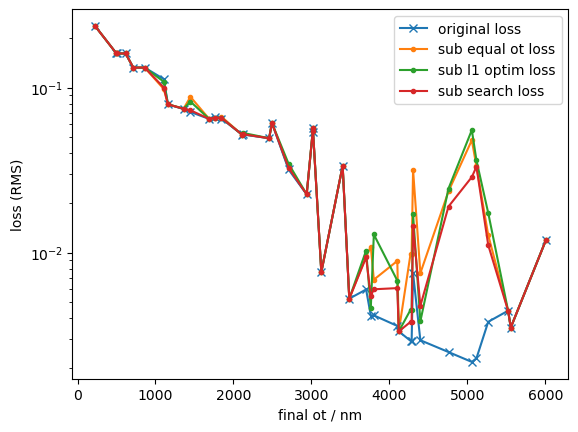

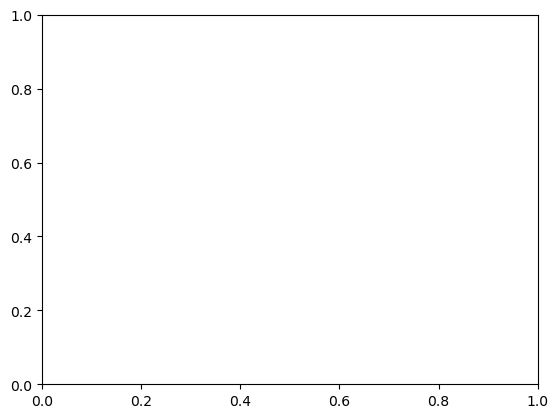

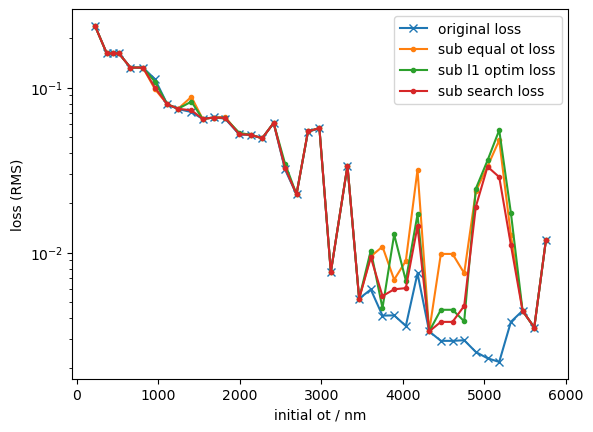

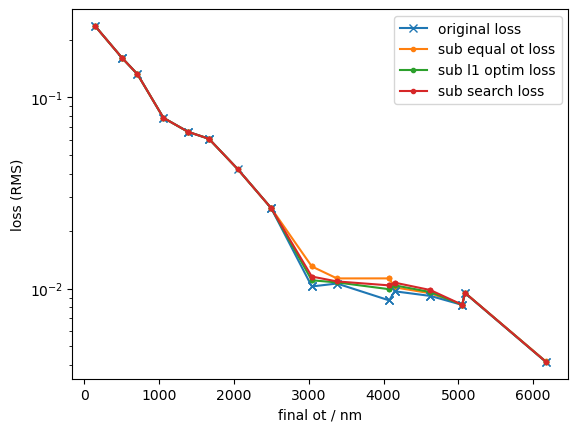

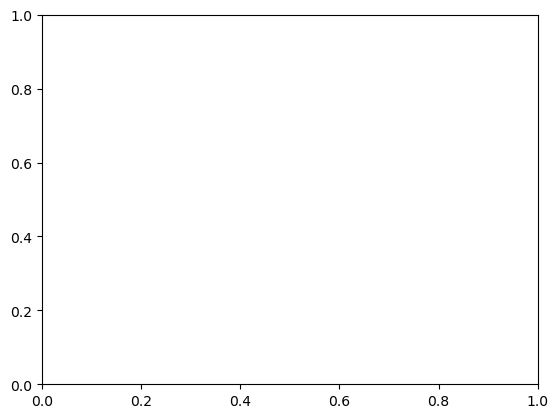

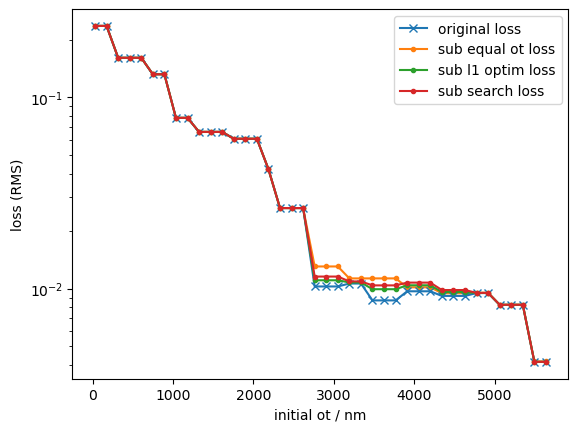

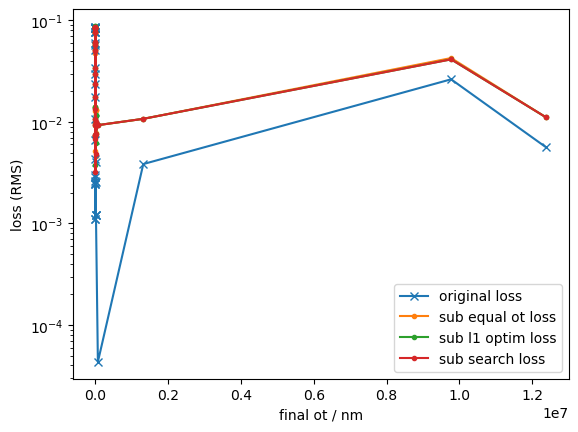

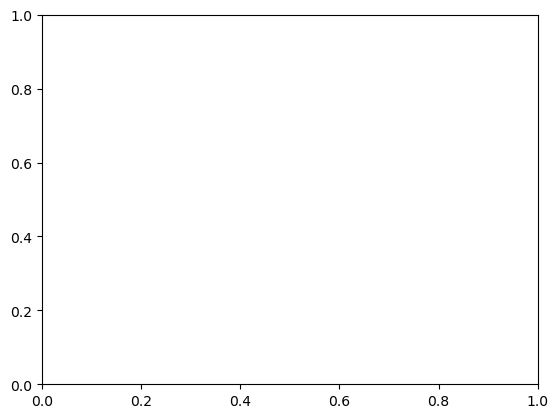

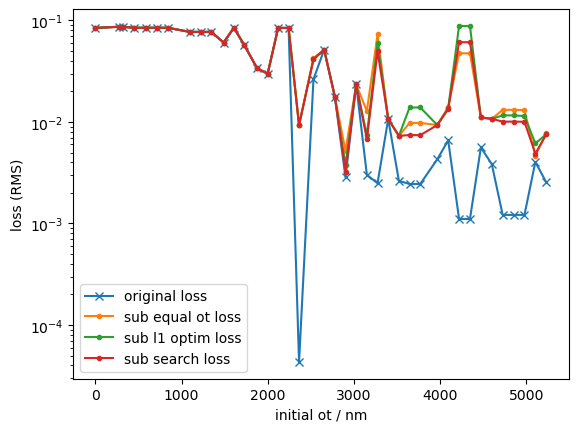

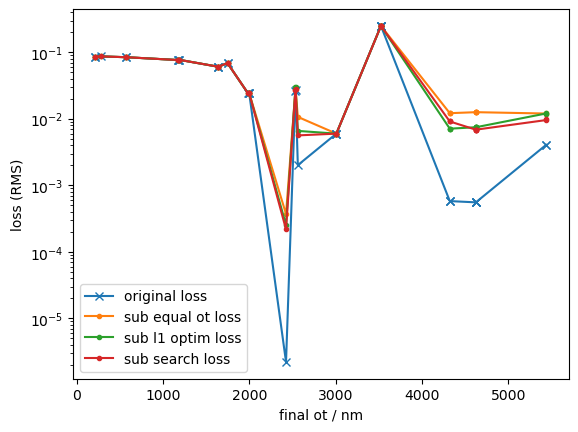

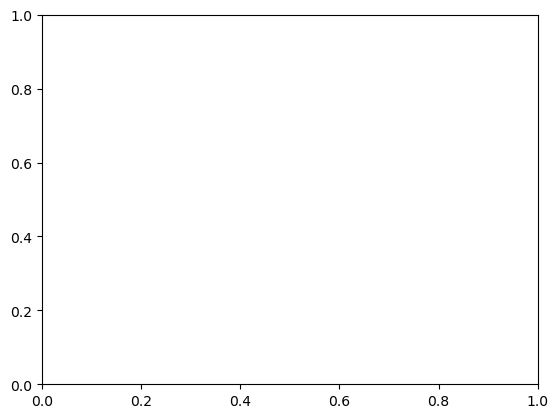

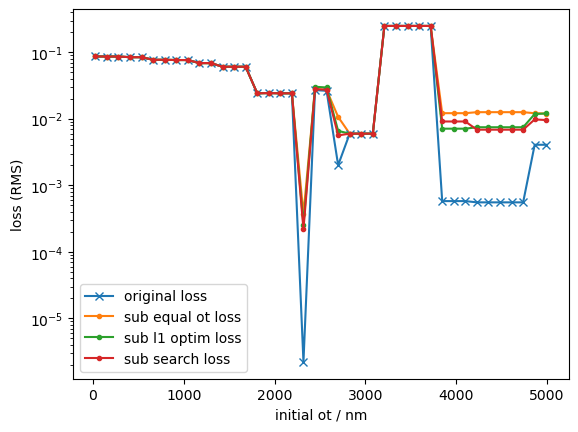

In [5]:
save_fig_dir_SiO2_target_30layers = './figs/50iters_0to2OT_200run_SiO2_target30layers/'
save_fig_dir_TiO2_target_30layers = './figs/50iters_0to2OT_200run_TiO2_target30layers/'
save_fig_dir_SiO2_target_4layers = './figs/50iters_0to2OT_200run_SiO2_target4layers/'
save_fig_dir_TiO2_target_4layers = './figs/50iters_0to2OT_200run_TiO2_target4layers/'


def plot_sub_on_trained_films(designs: list[DesignSimple], save_fig_dir):
    original_loss = []
    substituted_loss_eqaulOT = []
    substituted_loss_optim = []
    substituted_loss_search = []
    initial_ot = []
    final_ot = []
    d_min = 2 # nm
    for design in designs[::5]:
        f_sub_equal_ot = copy.deepcopy(design.film)
        equal_optical_thickness(f_sub_equal_ot, d_min)
        substituted_loss_eqaulOT.append(calculate_RMS(design.target_film, f_sub_equal_ot))

        f_sub_optim = copy.deepcopy(design.film)
        optimal_and_thin_film_approx_substitution_greedy_new(f_sub_optim, d_min)
        substituted_loss_optim.append(calculate_RMS(design.target_film, f_sub_optim))

        f_sub_search = copy.deepcopy(design.film)
        search_ot_substitution(f_sub_search, design.film, d_min)
        substituted_loss_search.append(calculate_RMS(design.target_film, f_sub_search))

        original_loss.append(design.calculate_loss())
        initial_ot.append(design.get_init_ot(wl))
        final_ot.append(design.get_current_ot(wl))


    fig, ax = plt.subplots(1, 1)
    # sort acording to final ot so that plot does not get messy
    [
        initial_ot,
        final_ot,
        original_loss,
        substituted_loss_eqaulOT,
        substituted_loss_optim,
        substituted_loss_search
    ] = [[a[i] for a in sorted(zip(
            initial_ot,
            final_ot,
            original_loss,
            substituted_loss_eqaulOT,
            substituted_loss_optim,
            substituted_loss_search
        ), key=lambda lists: lists[1]) # sorted according to final ot (index 1)
        ] for i in range(6) # 6 elems in one elem of the zip list
    ]
    ax.plot(final_ot, original_loss, label='original loss', marker='x', ls='-')
    ax.plot(final_ot, substituted_loss_eqaulOT, label='sub equal ot loss', marker='.', zorder=0, ls='-')
    ax.plot(final_ot, substituted_loss_optim, label='sub l1 optim loss', marker='.', ls='-')
    ax.plot(final_ot, substituted_loss_search, label='sub search loss', marker='.', ls='-')

    ax.legend()
    ax.set_xlabel('final ot / nm')
    ax.set_ylabel('loss (RMS)')

    fig.savefig(save_fig_dir + f'loss-final_ot_substitute_{d_min}nm_allowed.png', dpi=300)
    ax.set_yscale('log')
    fig.savefig(save_fig_dir + f'loss-final_ot_substitute_{d_min}nm_allowed_log.png', dpi=300)


    fig, ax = plt.subplots(1, 1)
    # sort acording to initial ot so that plot does not get messy
    (
        initial_ot,
        final_ot,
        original_loss,
        substituted_loss_eqaulOT,
        substituted_loss_optim,
        substituted_loss_search
    ) = [[a[i] for a in sorted(zip(
            initial_ot,
            final_ot,
            original_loss,
            substituted_loss_eqaulOT,
            substituted_loss_optim,
            substituted_loss_search
        ), key=lambda lists: lists[0])
        ] for i in range(6)
    ]

    fig, ax = plt.subplots(1, 1)
    ax.plot(initial_ot, original_loss, label='original loss', marker='x', ls='-')
    ax.plot(initial_ot, substituted_loss_eqaulOT, label='sub equal ot loss', marker='.', zorder=0, ls='-')
    ax.plot(initial_ot, substituted_loss_optim, label='sub l1 optim loss', marker='.', ls='-')
    ax.plot(initial_ot, substituted_loss_search, label='sub search loss', marker='.', ls='-')

    ax.legend()
    ax.set_xlabel('initial ot / nm')
    ax.set_ylabel('loss (RMS)')

    fig.savefig(save_fig_dir + f'loss-initial_ot_substitute_{d_min}nm_allowed.png', dpi=300)
    ax.set_yscale('log')
    fig.savefig(save_fig_dir + f'loss-initial_ot_substitute_{d_min}nm_allowed_log.png', dpi=300)


for designs, save_fig_dir in zip([designs_SiO2, designs_TiO2, designs_SiO2_target4, designs_TiO2_target4],
                                 [save_fig_dir_SiO2_target_30layers, save_fig_dir_TiO2_target_30layers, save_fig_dir_SiO2_target_4layers, save_fig_dir_TiO2_target_4layers]):
    plot_sub_on_trained_films(designs, save_fig_dir)

